In [770]:
import tensorflow as tf
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [771]:
def get_recent_time_series_batch(dataframe: pd.DataFrame, seq_length: int) -> tuple:
    target_column_name: str = "target"
    time_series_batch = []
    time_series_target = []

    for row in range(len(dataframe) - seq_length):
        time_series_batch.append(dataframe.iloc[row:row + seq_length].values)
        time_series_target.append(dataframe[target_column_name].iloc[row + seq_length - 1])

    time_series_batch:[[[]]] = np.array(time_series_batch)
    time_series_target: [] = np.array(time_series_target)
    return time_series_batch, time_series_target

"""
X is a list with contains (len(df) - seq_length) entries. The first entry is a list of the first seq_length rows of df. X[index][-1] gives you the (index + seq_length)-th row of df.
y is a list that contains (len(df) - seq_length) entries. The first entry is the "target" column of the seq_length row. X[index][-1][-1] and y[index] are the same "target" value.
If df has 5000 entries, X.shape y.shape will give you: ((4980, 10, 25), (4980,))
"""

'\nX is a list with contains (len(df) - seq_length) entries. The first entry is a list of the first seq_length rows of df. X[index][-1] gives you the (index + seq_length)-th row of df.\ny is a list that contains (len(df) - seq_length) entries. The first entry is the "target" column of the seq_length row. X[index][-1][-1] and y[index] are the same "target" value.\nIf df has 5000 entries, X.shape y.shape will give you: ((4980, 10, 25), (4980,))\n'

In [772]:
training_file_path: str = "data/TSLA_time_series.csv"
testing_file_path: str = "data/AMD_time_series.csv"

train_df = pd.read_csv(training_file_path)
test_df = pd.read_csv(testing_file_path)

print("Training Dataset shape:", train_df.shape)
print("Testing Dataset shape:", test_df.shape)

X, y = get_recent_time_series_batch(train_df, 10)
X_test, y_test = get_recent_time_series_batch(test_df, 10)

print("Training Dataset as time series batches:",X.shape, y.shape)
print("Testing Dataset as time series batches:",X_test.shape, y_test.shape)

test_size = 0.2

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=test_size,random_state=42)
print("Training sets shape:", X_train.shape, y_train.shape)
print("Validation sets shape:", X_val.shape, y_val.shape)
print("Test sets shape:", X_test.shape, y_test.shape)


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

print("Scaled training sets shape:", X_train.shape, y_train.shape)
print("Scaled validation sets shape:", X_val.shape, y_val.shape)
print("Scaled test sets shape:", X_test.shape, y_test.shape)

Training Dataset shape: (4990, 30)
Testing Dataset shape: (4990, 30)
Training Dataset as time series batches: (4980, 10, 30) (4980,)
Testing Dataset as time series batches: (4980, 10, 30) (4980,)
Training sets shape: (3984, 10, 30) (3984,)
Validation sets shape: (996, 10, 30) (996,)
Test sets shape: (4980, 10, 30) (4980,)
Scaled training sets shape: (3984, 10, 30) (3984,)
Scaled validation sets shape: (996, 10, 30) (996,)
Scaled test sets shape: (4980, 10, 30) (4980,)


In [773]:
from keras.src.layers import LSTM, Dropout, Dense
from keras import Sequential

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_val, y_val), callbacks=[early_stopping])
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/20
498/498 [==============================] - 5s 5ms/step - loss: 0.6781 - accuracy: 0.5858 - val_loss: 0.6078 - val_accuracy: 0.7892
Epoch 2/20
498/498 [==============================] - 2s 4ms/step - loss: 0.5988 - accuracy: 0.6940 - val_loss: 0.5222 - val_accuracy: 0.7831
Epoch 3/20
498/498 [==============================] - 2s 4ms/step - loss: 0.5236 - accuracy: 0.7631 - val_loss: 0.4598 - val_accuracy: 0.8102
Epoch 4/20
498/498 [==============================] - 2s 4ms/step - loss: 0.4774 - accuracy: 0.7982 - val_loss: 0.4054 - val_accuracy: 0.8464
Epoch 5/20
498/498 [==============================] - 2s 4ms/step - loss: 0.4246 - accuracy: 0.8326 - val_loss: 0.3549 - val_accuracy: 0.8624
Epoch 6/20
498/498 [==============================] - 2s 4ms/step - loss: 0.3931 - accuracy: 0.8404 - val_loss: 0.3190 - val_accuracy: 0.8725
Epoch 7/20
498/498 [==============================] - 2s 4ms/step - loss: 0.3534 - accuracy: 0.8650 - val_loss: 0.2913 - val_accuracy: 0.8855
Epoch 

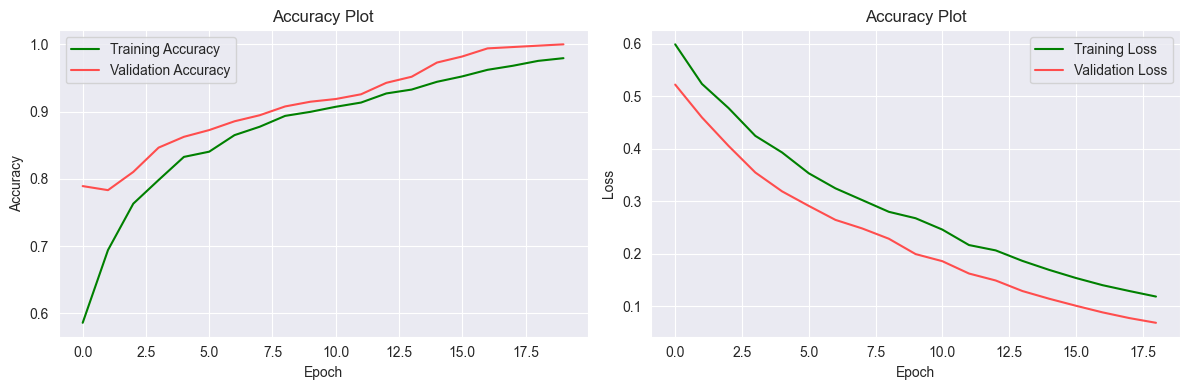

In [774]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'][0:], label='Training Accuracy', color="green")
ax1.plot(history.history['val_accuracy'][0:], label='Validation Accuracy', color="#ff4d4d")

ax1.set_title('Accuracy Plot')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'][1:], label='Training Loss', color="green")
ax2.plot(history.history['val_loss'][1:], label='Validation Loss', color="#ff4d4d")

ax2.set_title('Accuracy Plot')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [775]:
from collections import Counter

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

y_actual = y_test
element_counts = Counter(y_actual)

for element, count in element_counts.items():
    print(f"{element}: {count} occurrences")

results_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred.flatten(), 'Predicted_Prob': y_pred_prob.flatten()})
results_df

156/156 [==============================] - 0s 2ms/step - loss: 0.3104 - accuracy: 0.8934
Test Loss: 0.3104, Test Accuracy: 89.34%
156/156 [==============================] - 1s 2ms/step
Accuracy: 0.8934
Precision: 0.8512
Recall: 0.9624
F1 Score: 0.9034
AUC-ROC: 0.8908
0: 2400 occurrences
1: 2580 occurrences


,Actual,Predicted,Predicted_Prob
0,0,0,0.159045
1,0,0,0.214984
2,0,0,0.266905
3,0,0,0.292470
4,0,0,0.333371
5,0,0,0.358814
6,0,0,0.369571
7,0,0,0.394102
8,0,0,0.405239
9,0,0,0.401269


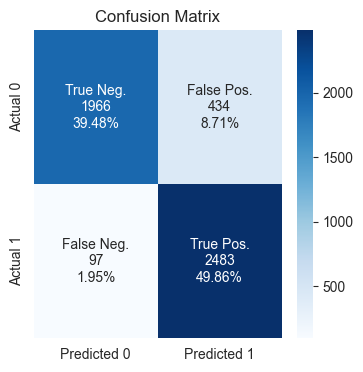

In [776]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))

group_names = ["True Neg.","False Pos.","False Neg.","True Pos."]
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues', cbar=True, xticklabels=['Predicted 0', 'Predicted 1'],yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()